In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
from keras import backend as K
import pickle

Using TensorFlow backend.


### Experiment data processing

In [2]:
results = {}
for process in range(3):
    results_add = pickle.load(open('MNISTNetRegComparisonReluN10BigKRepeatScale/results_repeat%d.pkl' % process, 'rb'))
    results = {**results, **results_add}

In [3]:
Layers = 10
KLips = 10
NNeurons = 10
activation = 'relu'
scaler = 1.0
epochs = 500
inputs = 1000
acc_param = 1000
pfirst_options = np.linspace(0, 0.2, 6)[1:-1]
reg_type_options = ['delta', 'l1', 'l2', 0]
reg_coeff_options = [0] + list(np.logspace(-10, 0, 6))
repetitions = list(range(4))

In [4]:
def plot_results_err(reg_type, p):
    # pfirst, reg_type, reg_coeff, repetition
    plt.figure()
    plt.title('Error for method %s p = %f' % (reg_type, p))
    plt.xlabel('Reg coefficient')
    plt.ylabel('Error')
    x = reg_coeff_options[1:]
    for rep in repetitions:
        acc = []
        acc_o = []
        for reg_coeff in reg_coeff_options[1:]:
            data = results[(p, reg_type, reg_coeff, rep)]
            acc.append(data['mean_exp'])
            acc_o.append(data['mean_bound'])
        plt.plot(x, acc, label = 'Mean exp' if rep == 0 else None, c = 'red')
        plt.plot(x, acc_o, label = 'Mean bound' if rep == 0 else None, c = 'green')
        
        plt.plot(x, [results[(p, reg_type, 0, rep)]['mean_exp']] * len(x), c = 'red')
        plt.plot(x, [results[(p, reg_type, 0, rep)]['mean_bound']] * len(x), c = 'green')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()

In [5]:
def plot_results(reg_type, p):
    # pfirst, reg_type, reg_coeff, repetition
    plt.figure()
    plt.title('Accuracy for method %s p = %f' % (reg_type, p))
    plt.xlabel('Reg coefficient')
    plt.ylabel('Accuracy')
    x = reg_coeff_options[1:]
    for rep in repetitions:
        acc = []
        acc_o = []
        for reg_coeff in reg_coeff_options[1:]:
            data = results[(p, reg_type, reg_coeff, rep)]
            acc.append(data['acc_dropout'])
            acc_o.append(data['acc_orig'])
        plt.plot(x, acc, label = 'Accuracy w dropout' if rep == 0 else None, c = 'red')
        plt.plot(x, acc_o, label = 'Accuracy no dropout' if rep == 0 else None, c = 'green')
        
        plt.plot(x, [results[(p, reg_type, 0, rep)]['acc_dropout']] * len(x), c = 'red')
        plt.plot(x, [results[(p, reg_type, 0, rep)]['acc_orig']] * len(x), c = 'green')
    plt.xscale('log')
    plt.legend()
    plt.show()

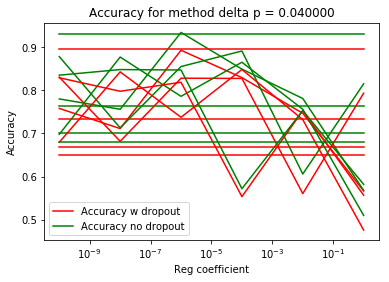

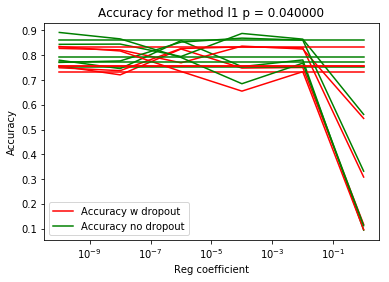

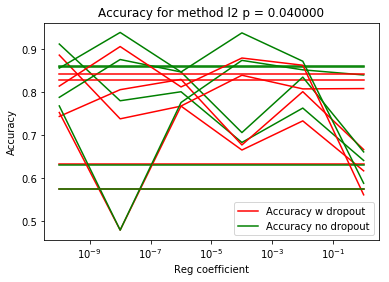

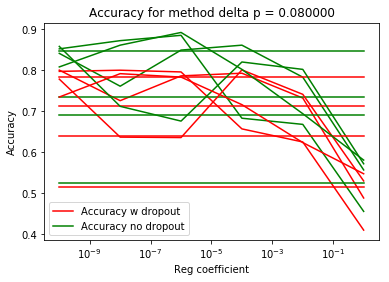

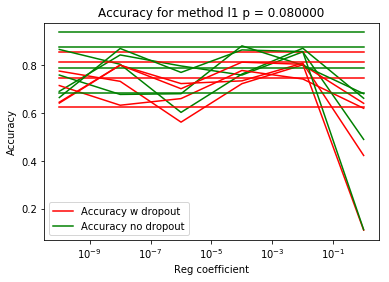

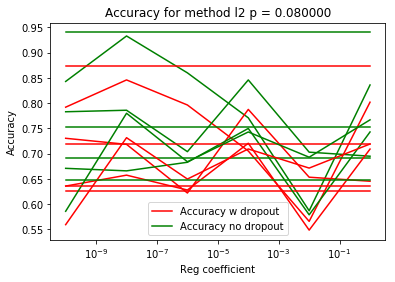

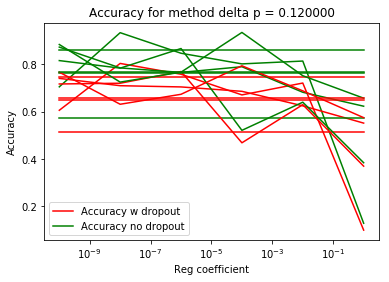

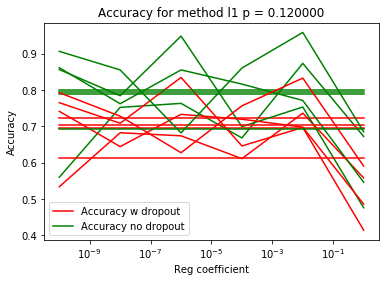

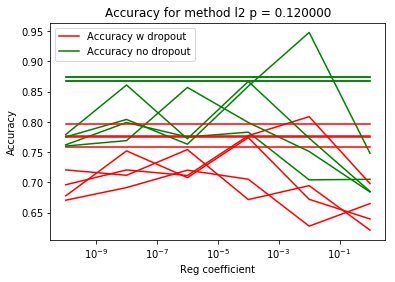

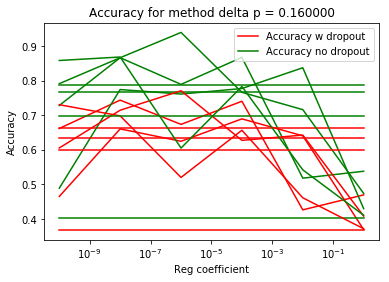

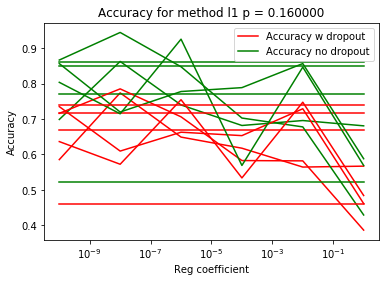

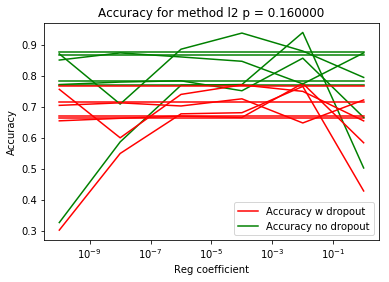

In [6]:
for p in pfirst_options:
    for reg_type in reg_type_options[:-1]:
        plot_results(reg_type, p)

In [7]:
best_orig = {x: [] for x in reg_type_options[:-1]}
best_dropout = {x: [] for x in reg_type_options[:-1]}
argmax_dropout = []
for p in pfirst_options:
    for reg_type in reg_type_options[:-1]:
        do_data = [np.mean([results[(p, reg_type, reg_coeff, rep)]['acc_dropout'] for rep in repetitions]) for reg_coeff in reg_coeff_options[1:]]
        argmax_dropout += [np.argmax(do_data)]
        print(reg_coeff_options[argmax_dropout[-1]])
        acc_do = np.max(do_data)
        orig_data = [np.mean([results[(p, reg_type, reg_coeff, rep)]['acc_orig'] for rep in repetitions]) for reg_coeff in reg_coeff_options[1:]]
        acc_orig = np.max(orig_data)
        best_dropout[reg_type] += [acc_do]
        best_orig[reg_type] += [acc_orig]

{'delta': [0.81919825, 0.777556, 0.72648025, 0.7040124999999999], 'l1': [0.7921317499999999, 0.7891545000000001, 0.740711, 0.693371], 'l2': [0.80118025, 0.73841, 0.73196275, 0.7339424999999999]}


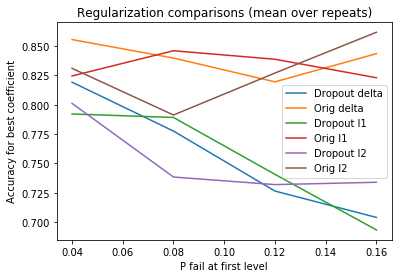

In [8]:
print(best_dropout)
plt.figure()
plt.title('Regularization comparisons (mean over repeats)')
plt.xlabel('P fail at first level')
plt.ylabel('Accuracy for best coefficient')
for reg_type in reg_type_options[:-1]:
    plt.plot(pfirst_options, best_dropout[reg_type], label = 'Dropout %s' % reg_type)
    plt.plot(pfirst_options, best_orig[reg_type], label = 'Orig %s' % reg_type)
plt.legend()
plt.show()

In [9]:
best_exp = {x: [] for x in reg_type_options[:-1]}
best_bound = {x: [] for x in reg_type_options[:-1]}
for p in pfirst_options:
    for i, reg_type in enumerate(reg_type_options[:-1]):
        exp_data = [np.mean([results[(p, reg_type, reg_coeff, rep)]['mean_exp'] for rep in repetitions]) for reg_coeff in reg_coeff_options[1:]]
        bound_data = [np.mean([results[(p, reg_type, reg_coeff, rep)]['mean_bound'] for rep in repetitions]) for reg_coeff in reg_coeff_options[1:]]
        best_exp[reg_type] += [exp_data[argmax_dropout[i]]]
        best_bound[reg_type] += [bound_data[argmax_dropout[i]]]

{'delta': [11.237735, 27.401764, 31.561956, 42.013424], 'l1': [11.445982, 23.778973, 39.5368, 40.539963], 'l2': [11.975496, 21.060349, 33.021652, 40.06764]}


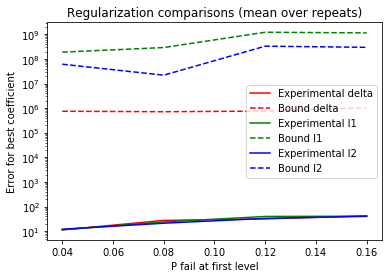

In [10]:
print(best_exp)
plt.figure()
plt.title('Regularization comparisons (mean over repeats)')
plt.xlabel('P fail at first level')
plt.ylabel('Error for best coefficient')
colors = ['red', 'green', 'blue']
for reg_type in reg_type_options[:-1]:
    plt.plot(pfirst_options, best_exp[reg_type], label = 'Experimental %s' % reg_type, c = colors[0])
    plt.plot(pfirst_options, best_bound[reg_type], '--',label = 'Bound %s' % reg_type, c = colors[0])
    colors = colors[1:]
plt.yscale('log')
plt.legend()
plt.show()

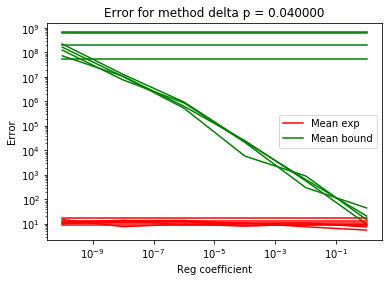

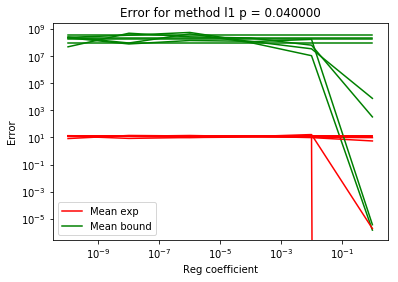

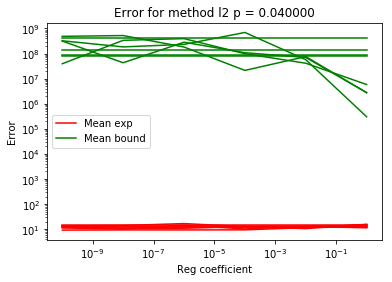

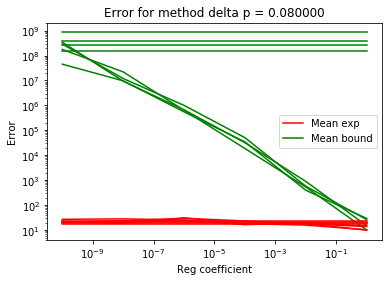

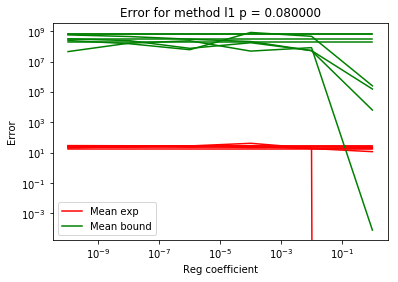

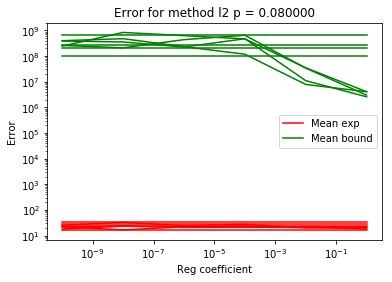

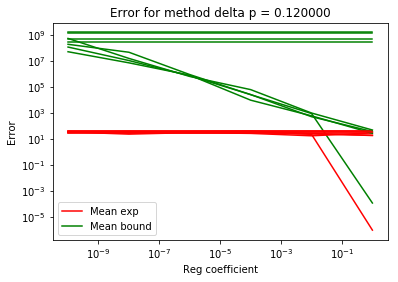

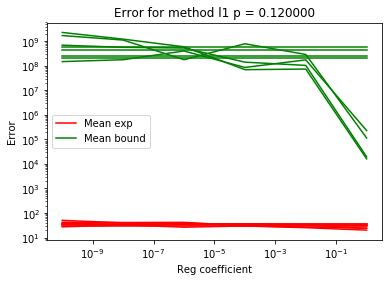

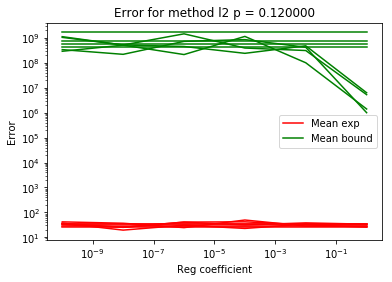

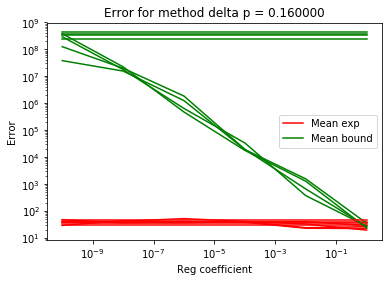

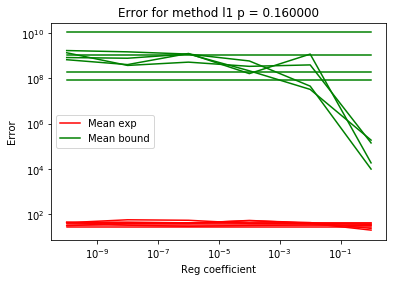

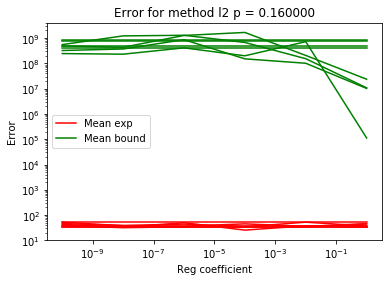

In [11]:
for p in pfirst_options:
    for reg_type in reg_type_options[:-1]:
        plot_results_err(reg_type, p)